train data

processing train data 0/3600
0.09862753672859252


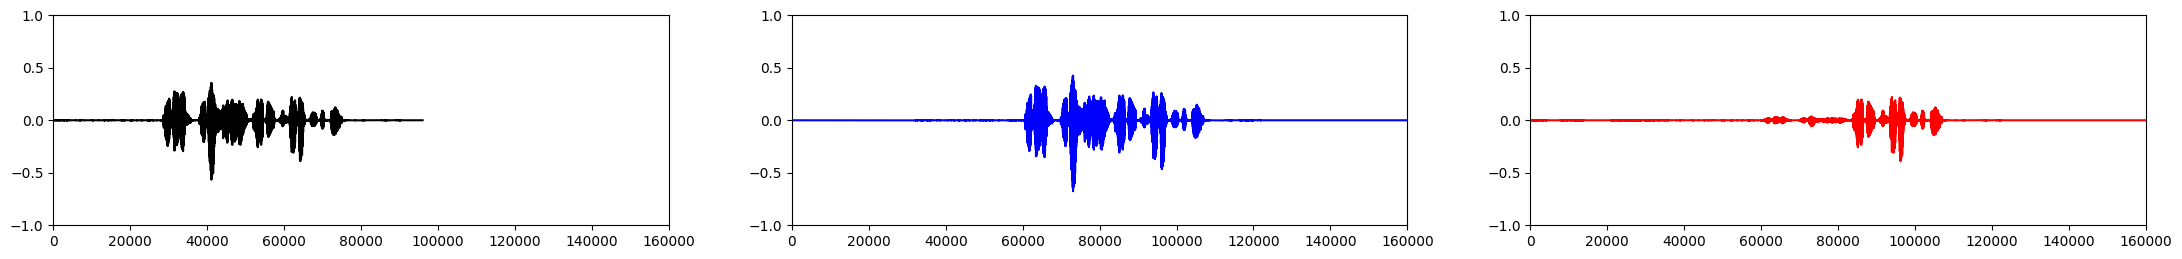

In [6]:
import matplotlib.pyplot as plt
import random
import soundfile as sf
import numpy as np


import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

write = False

samples_by_speaker = 10 # <=30
train_samples = samples_by_speaker * 360
valid_samples = samples_by_speaker * 40

assert samples_by_speaker <= 30

for i in range(train_samples):
    if i % 100 == 0:
        print('processing train data {0}/{1}'.format(i, train_samples))
    wav_seq = []
    if write:
        filenum = i
    else:
        filenum = random.randint(0, train_samples - 1)
    wav, sr = sf.read('/home/yhjeon/data/SITEC/SITEC/{0:d}{1:03d}{2:03d}.wav'.format(filenum//(180*samples_by_speaker)+1, (filenum//samples_by_speaker)%180+1, filenum%samples_by_speaker+1))
    
    if len(wav) > 96000:
        wav_seq = wav[0:96000]
    else:
        wav_seq = np.concatenate((wav , [0 for _ in range(96000 - len(wav))]))
    
    power = np.array(np.split(wav_seq[0:48000], 100))
    power = np.sqrt(np.mean(np.square(power), axis=1))
    power = np.max(power)
    original_wav_seq = wav_seq / (power * 5)

    distortion_start_time = int((1.5 + random.random() * 1.5) * 16000) 
    distortion_duration = int((1.0 + random.random() * 1.0) * 16000)
    distortion_gain = 4 ** random.gauss(0, 1)
    distortion_mask = np.concatenate([np.array([1 for _ in range(distortion_start_time)]), np.array([distortion_gain for _ in range(distortion_duration)]), np.array([1 for _ in range(96000 - distortion_duration - distortion_start_time)])])
    distorted_wav_seq = np.clip(wav_seq * distortion_mask, -1, 1)

    silence = np.random.randn(32000) * 0.0000
    white_noise = np.random.randn(32000) * 0.0001

    original_wav_seq = np.concatenate((silence, original_wav_seq, silence))
    distorted_wav_seq = np.concatenate((white_noise, distorted_wav_seq, white_noise))

    if write:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/train/original/original_{}.wav'.format(filenum), original_wav_seq, samplerate=16000)
    
    else:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/original.wav', original_wav_seq, samplerate=16000)

    if write:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/train/distorted/distorted_{0}_{1}_{2}_{3}.wav'.format(filenum, distortion_start_time, distortion_duration, distortion_gain), distorted_wav_seq, 16000)
    
    else:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/distorted.wav', distorted_wav_seq, 16000)

    if not write:
        print(distortion_gain)
        plt.figure(figsize=[27, 6])
        plt.subplot(2, 3, 1)
        plt.axis([0, 160000, -1, 1])
        plt.plot(wav_seq, color='black')
        plt.subplot(2, 3, 2)
        plt.axis([0, 160000, -1, 1])
        plt.plot(original_wav_seq, color='blue')
        plt.subplot(2, 3, 3)
        plt.axis([0, 160000, -1, 1])
        plt.plot(distorted_wav_seq, color='red')
        #plt.subplot(2, 3, 4)
        #plt.axis([0, 1000, -0.1, 1.1])
        #plt.plot(vad_label, color='red')
        plt.show()
        break

In [2]:
import matplotlib.pyplot as plt
import random
import soundfile as sf
import numpy as np


import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

write = True


for i in range(train_samples):
    if i % 100 == 0:
        print('processing train data {0}/{1}'.format(i, train_samples))
    wav_seq = []
    if write:
        filenum = i
    else:
        filenum = random.randint(0, train_samples - 1)
    
    wav1, _ = sf.read('/home/yhjeon/data/SITEC/SITEC/{0:d}{1:03d}{2:03d}.wav'.format(filenum//(samples_by_speaker*180)+1, (filenum//samples_by_speaker)%180+1, filenum%samples_by_speaker+samples_by_speaker+1))
    wav2, _ = sf.read('/home/yhjeon/data/SITEC/SITEC/{0:d}{1:03d}{2:03d}.wav'.format(filenum//(samples_by_speaker*180)+1, (filenum//samples_by_speaker)%180+1, filenum%samples_by_speaker+samples_by_speaker*2+1))
    wav_len1 = random.randint(48000, 64000)
    wav_len2 = random.randint(48000, 64000)
    silence_len = 160000 - wav_len1 - wav_len2
    wav_seq1 = wav1[16000:wav_len1+16000]
    wav_seq2 = wav2[16000:wav_len2+16000]
    silence = np.random.randn(silence_len) * 0.0000
    white_noise = np.random.randn(silence_len) * 0.0001

    if len(wav_seq1) < wav_len1:
        wav_seq1 = np.concatenate((wav_seq1, [0 for _ in range(wav_len1 - len(wav_seq1))]))
    if len(wav_seq2) < wav_len2:
        wav_seq2 = np.concatenate((wav_seq2, [0 for _ in range(wav_len2 - len(wav_seq2))]))

    fadeout_time = 4800
    linear_fadeout_mask = np.array([(fadeout_time - i) / fadeout_time for i in range(fadeout_time)])
    fadeout_mask1 = np.concatenate([np.ones(wav_len1 - fadeout_time), linear_fadeout_mask])
    fadeout_mask2 = np.concatenate([np.ones(wav_len2 - fadeout_time), linear_fadeout_mask])

    wav_seq1 = wav_seq1 * fadeout_mask1
    wav_seq2 = wav_seq2 * fadeout_mask2
    
    wav_seq = np.concatenate([wav_seq1, silence, wav_seq2])

    power1 = np.array(np.split(wav_seq1[0:32000], 100))
    power1 = np.sqrt(np.mean(np.square(power1), axis=1))
    power1 = np.max(power1)
    power2 = np.array(np.split(wav_seq2[0:32000], 100))
    power2 = np.sqrt(np.mean(np.square(power2), axis=1))
    power2 = np.max(power2)

    wav_seq1 = wav_seq1 / (power1 * 5)
    wav_seq2 = wav_seq2 / (power2 * 5)
    original_wav_seq = np.concatenate([wav_seq1, silence, wav_seq2])

    gain1 = 4 ** random.gauss(0, 1)
    gain2 = 4 ** random.gauss(0, 1)
    wav_seq1 = wav_seq1 * gain1
    wav_seq2 = wav_seq2 * gain2

    distorted_wav_seq = np.clip(np.concatenate([wav_seq1, white_noise, wav_seq2]), -1, 1)

    if write:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/train/original/original_{}.wav'.format(filenum+train_samples), original_wav_seq, samplerate=16000)
    else:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/original.wav'.format(filenum), original_wav_seq, samplerate=16000)

    
    if write:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/train/distorted/distorted_{0}_{1}_{2}.wav'.format(filenum+train_samples, gain1, gain2), distorted_wav_seq, 16000)
    else:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/distorted.wav'.format(filenum, distortion_start_time, distortion_duration, distortion_gain), distorted_wav_seq, 16000)

    if not write:
        plt.figure(figsize=[27, 6])
        plt.subplot(2, 3, 1)
        plt.axis([0, 160000, -1, 1])
        plt.plot(wav_seq, color='black')
        plt.subplot(2, 3, 2)
        plt.axis([0, 160000, -1, 1])
        plt.plot(original_wav_seq, color='blue')
        plt.subplot(2, 3, 3)
        plt.axis([0, 160000, -1, 1])
        plt.plot(distorted_wav_seq, color='red')
        #plt.subplot(2, 3, 4)
        #plt.axis([0, 1000, -0.1, 1.1])
        #plt.plot(vad_label, color='red')
        plt.show()
        break

processing train data 0/3600
processing train data 100/3600
processing train data 200/3600
processing train data 300/3600
processing train data 400/3600
processing train data 500/3600
processing train data 600/3600
processing train data 700/3600
processing train data 800/3600
processing train data 900/3600
processing train data 1000/3600
processing train data 1100/3600
processing train data 1200/3600
processing train data 1300/3600
processing train data 1400/3600
processing train data 1500/3600
processing train data 1600/3600
processing train data 1700/3600
processing train data 1800/3600
processing train data 1900/3600
processing train data 2000/3600
processing train data 2100/3600
processing train data 2200/3600
processing train data 2300/3600
processing train data 2400/3600
processing train data 2500/3600
processing train data 2600/3600
processing train data 2700/3600
processing train data 2800/3600
processing train data 2900/3600
processing train data 3000/3600
processing train dat

valid data

In [3]:
write = True

for i in range(valid_samples):
    if i % 100 == 0:
        print('processing valid data {0}/{1}'.format(i, valid_samples))
    wav_seq = []
    if write:
        filenum = i
    else:
        filenum = random.randint(0, valid_samples - 1)
    wav, sr = sf.read('/home/yhjeon/data/SITEC/SITEC/{0:d}{1:03d}{2:03d}.wav'.format(filenum//(20*samples_by_speaker)+1, (filenum//samples_by_speaker)%20+181, filenum%samples_by_speaker+1))
    
    if len(wav) > 96000:
        wav_seq = wav[0:96000]
    else:
        wav_seq = np.concatenate((wav , [0 for _ in range(96000 - len(wav))]))
    
    power = np.array(np.split(wav_seq[0:48000], 100))
    power = np.sqrt(np.mean(np.square(power), axis=1))
    power = np.max(power)
    original_wav_seq = wav_seq / (power * 5)

    distortion_start_time = int((1.5 + random.random() * 1.5) * 16000) 
    distortion_duration = int((1.0 + random.random() * 1.0) * 16000)
    distortion_gain = 4 ** random.gauss(0, 1)
    distortion_mask = np.concatenate([np.array([1 for _ in range(distortion_start_time)]), np.array([distortion_gain for _ in range(distortion_duration)]), np.array([1 for _ in range(96000 - distortion_duration - distortion_start_time)])])
    distorted_wav_seq = np.clip(wav_seq * distortion_mask, -1, 1)

    silence = np.random.randn(32000) * 0.0000
    white_noise = np.random.randn(32000) * 0.0001

    original_wav_seq = np.concatenate((silence, original_wav_seq, silence))
    distorted_wav_seq = np.concatenate((white_noise, distorted_wav_seq, white_noise))
    
    if write:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/original/original_{}.wav'.format(filenum), original_wav_seq, samplerate=16000)
    
    else:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/original.wav', original_wav_seq, samplerate=16000)

    if write:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/distorted/distorted_{0}_{1}_{2}_{3}.wav'.format(filenum, distortion_start_time, distortion_duration, distortion_gain), distorted_wav_seq, 16000)
    
    else:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/distorted.wav', distorted_wav_seq, 16000)

    if not write:
        plt.figure(figsize=[27, 6])
        plt.subplot(2, 3, 1)
        plt.axis([0, 160000, -1, 1])
        plt.plot(wav_seq, color='black')
        plt.subplot(2, 3, 2)
        plt.axis([0, 160000, -1, 1])
        plt.plot(original_wav_seq, color='blue')
        plt.subplot(2, 3, 3)
        plt.axis([0, 160000, -1, 1])
        plt.plot(distorted_wav_seq, color='red')
        #plt.subplot(2, 3, 4)
        #plt.axis([0, 1000, -0.1, 1.1])
        #plt.plot(vad_label, color='red')
        plt.show()
        break
    


processing valid data 0/400
processing valid data 100/400
processing valid data 200/400
processing valid data 300/400


In [4]:
write = True


for i in range(valid_samples):
    if i % 100 == 0:
        print('processing valid data {0}/{1}'.format(i, valid_samples))
    wav_seq = []
    if write:
        filenum = i
    else:
        filenum = random.randint(0, valid_samples - 1)
    
    wav1, _ = sf.read('/home/yhjeon/data/SITEC/SITEC/{0:d}{1:03d}{2:03d}.wav'.format(filenum//(samples_by_speaker*20)+1, (filenum//samples_by_speaker)%20+181, filenum%samples_by_speaker+samples_by_speaker+1))
    wav2, _ = sf.read('/home/yhjeon/data/SITEC/SITEC/{0:d}{1:03d}{2:03d}.wav'.format(filenum//(samples_by_speaker*20)+1, (filenum//samples_by_speaker)%20+181, filenum%samples_by_speaker+samples_by_speaker*2+1))
    wav_len1 = random.randint(48000, 64000)
    wav_len2 = random.randint(48000, 64000)
    silence_len = 160000 - wav_len1 - wav_len2
    wav_seq1 = wav1[16000:wav_len1+16000]
    wav_seq2 = wav2[16000:wav_len2+16000]
    silence = np.random.randn(silence_len) * 0.0000
    white_noise = np.random.randn(silence_len) * 0.0001

    if len(wav_seq1) < wav_len1:
        wav_seq1 = np.concatenate((wav_seq1, [0 for _ in range(wav_len1 - len(wav_seq1))]))
    if len(wav_seq2) < wav_len2:
        wav_seq2 = np.concatenate((wav_seq2, [0 for _ in range(wav_len2 - len(wav_seq2))]))

    fadeout_time = 4800
    linear_fadeout_mask = np.array([(fadeout_time - i) / fadeout_time for i in range(fadeout_time)])
    fadeout_mask1 = np.concatenate([np.ones(wav_len1 - fadeout_time), linear_fadeout_mask])
    fadeout_mask2 = np.concatenate([np.ones(wav_len2 - fadeout_time), linear_fadeout_mask])

    wav_seq1 = wav_seq1 * fadeout_mask1
    wav_seq2 = wav_seq2 * fadeout_mask2
    
    wav_seq = np.concatenate([wav_seq1, silence, wav_seq2])

    power1 = np.array(np.split(wav_seq1[0:32000], 100))
    power1 = np.sqrt(np.mean(np.square(power1), axis=1))
    power1 = np.max(power1)
    power2 = np.array(np.split(wav_seq2[0:32000], 100))
    power2 = np.sqrt(np.mean(np.square(power2), axis=1))
    power2 = np.max(power2)

    wav_seq1 = wav_seq1 / (power1 * 5)
    wav_seq2 = wav_seq2 / (power2 * 5)
    original_wav_seq = np.concatenate([wav_seq1, silence, wav_seq2])

    gain1 = 4 ** random.gauss(0, 1)
    gain2 = 4 ** random.gauss(0, 1)
    wav_seq1 = wav_seq1 * gain1
    wav_seq2 = wav_seq2 * gain2

    distorted_wav_seq = np.clip(np.concatenate([wav_seq1, white_noise, wav_seq2]), -1, 1)

    if write:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/original/original_{}.wav'.format(filenum+valid_samples), original_wav_seq, samplerate=16000)
    else:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/original.wav'.format(filenum), original_wav_seq, samplerate=16000)

    if write:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/distorted/distorted_{0}_{1}_{2}.wav'.format(filenum+valid_samples, gain1, gain2), distorted_wav_seq, 16000)
    else:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/distorted.wav'.format(filenum, distortion_start_time, distortion_duration, distortion_gain), distorted_wav_seq, 16000)

    if not write:
        plt.figure(figsize=[27, 6])
        plt.subplot(2, 3, 1)
        plt.axis([0, 160000, -1, 1])
        plt.plot(wav_seq, color='black')
        plt.subplot(2, 3, 2)
        plt.axis([0, 160000, -1, 1])
        plt.plot(original_wav_seq, color='blue')
        plt.subplot(2, 3, 3)
        plt.axis([0, 160000, -1, 1])
        plt.plot(distorted_wav_seq, color='red')
        #plt.subplot(2, 3, 4)
        #plt.axis([0, 1000, -0.1, 1.1])
        #plt.plot(vad_label, color='red')
        plt.show()
        break

processing valid data 0/400
processing valid data 100/400
processing valid data 200/400
processing valid data 300/400


In [5]:
import os

remove = False

train_distorted = 0
train_original = 0
valid_distorted = 0
valid_original = 0

dir = '/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/train/distorted/'
for _, _, files in os.walk(dir):
    for file in files:
        if remove:
            os.remove(dir+file)
        else:
            train_distorted += 1

dir = '/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/train/original/'
for _, _, files in os.walk(dir):
    for file in files:
        if remove:
            os.remove(dir+file)
        else:
            train_original += 1

dir = '/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/distorted/'
for _, _, files in os.walk(dir):
    for file in files:
        if remove:
            os.remove(dir+file)
        else:
            valid_distorted += 1

dir = '/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/original/'
for _, _, files in os.walk(dir):
    for file in files:
        if remove:
            os.remove(dir+file)
        else:
            valid_original += 1

print(train_distorted, train_original, valid_distorted, valid_original)

7200 7200 800 800
